# Data Modelling and Evaluation

## Objectives

* Fulfil project objective - use the data insights gained from the DataVisualisation notebook to train the ML model to make predictions on whether leaves are infected or not

## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation

## Outputs

* 

## Additional Comments

* No additional comments




---

# Import Libraries

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
sns.set_style("white")
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image 

---

# Change working directory

Access the current directory with os.getcwd()

In [2]:
cwd = os.getcwd()

Set new directory

In [3]:
os.chdir('/workspace/Mildew-Detection')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/Mildew-Detection'

# Set Input Directories


In [16]:
my_data_dir = '/workspace/Mildew-Detection/inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set Output Directory

In [6]:
# If new version needed, just change version variable
version = 'v1'

file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


---

# Set Label Names

In [13]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Number of Images in Sets 

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




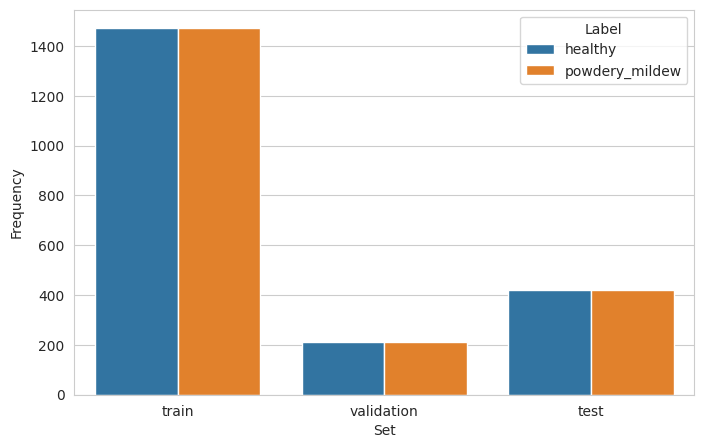

In [8]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Image Augmentation

Image augmentation using tensorflow

In [38]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Apply augmentation to sets 

In [40]:
batch_size = 20
train_set = augment_data.flow_from_directory(train_path,
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True
                                            )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [26]:
batch_size = 20
validation_set = augment_data.flow_from_directory(val_path,
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True
                                            )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [27]:
batch_size = 20
test_set = augment_data.flow_from_directory(test_path,
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True
                                            )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot augmented train image examples

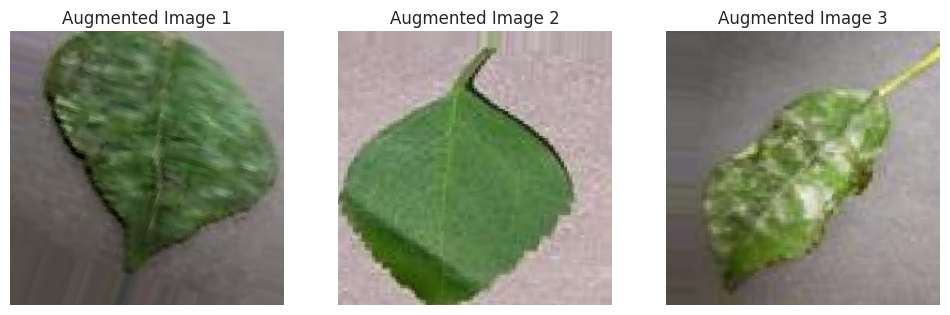

In [41]:

plt.figure(figsize=(12, 4)) 

for i in range(3):
    img_batch, label_batch = next(train_set)  
    img = img_batch[0] 


    img = img.astype('float32') 
    if np.max(img) > 1:
        img /= 255.0  

    # Plot images
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.show()

---

# Conclusions and Next Steps

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.